Training:  51%|█████     | 51/100 [00:07<00:07,  6.63epoch/s]

Epoch 50: Train Loss = 0.0161


Training: 100%|██████████| 100/100 [00:15<00:00,  6.42epoch/s]


Epoch 100: Train Loss = 0.0136


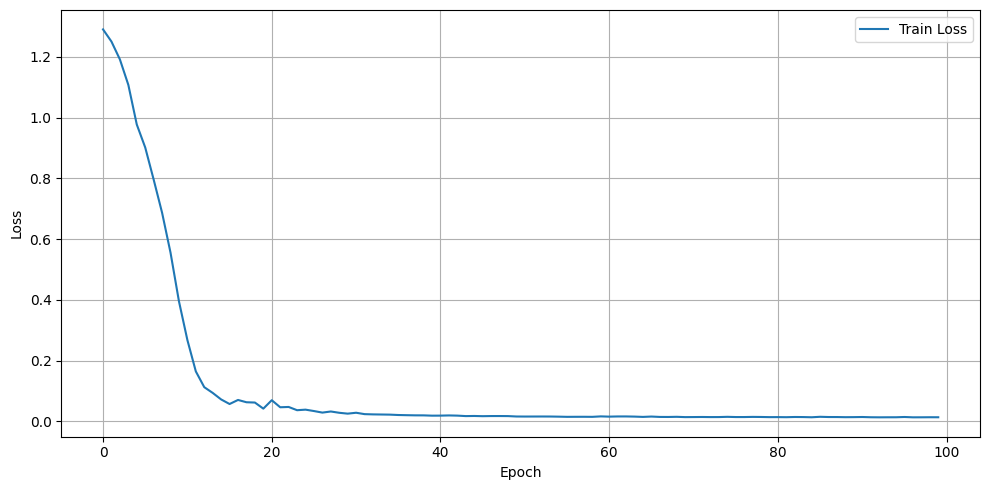

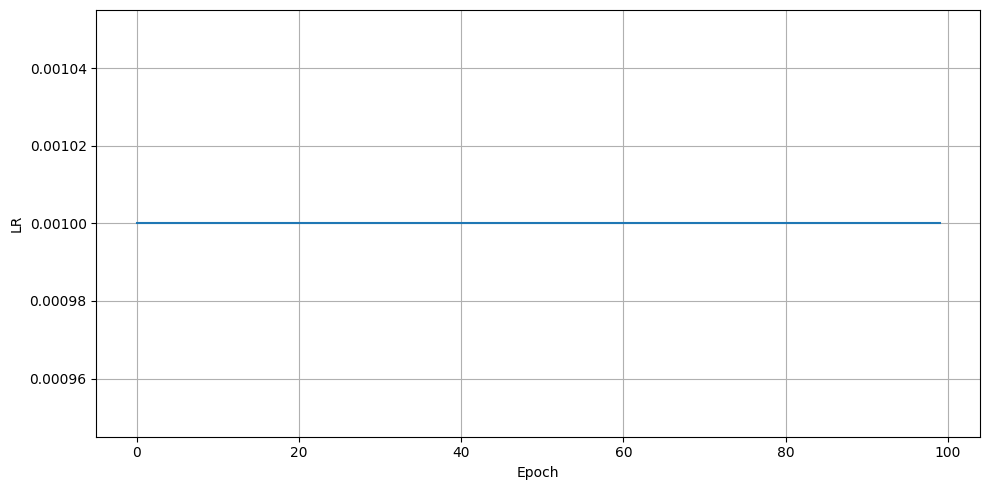

In [1]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import numpy as np
import torch
from foreblocks import TimeSeriesSeq2Seq
from foreblocks import ModelConfig
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 1000  # Total synthetic time series length

model_config = ModelConfig(
    model_type='lstm',
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    target_len=target_len,
    seq_len=seq_len,
    dropout=0.1,
    dim_feedforward=2048,
    nheads=4,
    num_encoder_layers=num_layers,
    num_decoder_layers=num_layers,
    input_processor_output_size=1)

pipeline = TimeSeriesSeq2Seq(model_config=model_config)


#  Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + np.cos(np.linspace(0, 100 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

X, Y, raw = pipeline.preprocess(time_series, window_size=seq_len, horizon=target_len)

train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

# Create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


history = pipeline.train_model(train_loader)

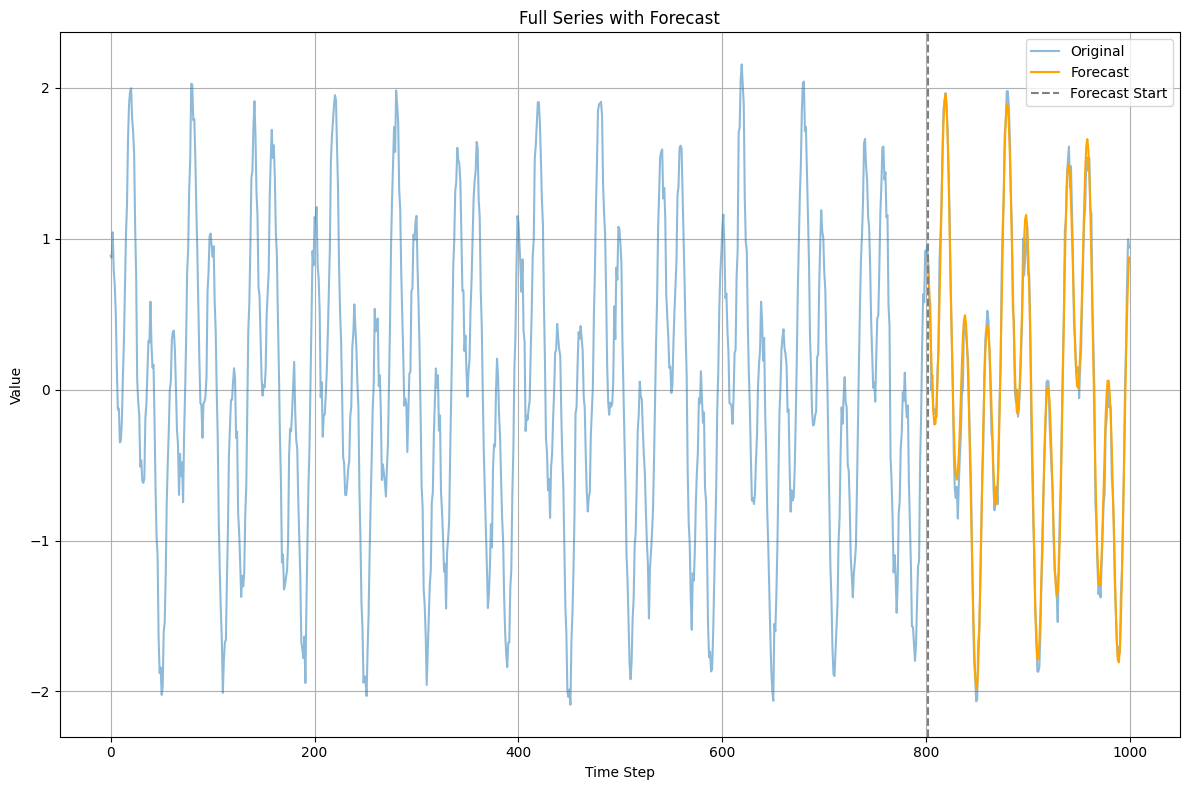

In [2]:
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)
raw = torch.tensor(raw, dtype=torch.float32)

pipeline.plot_prediction(X_val, Y_val, full_series=raw, offset=train_size)